In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import keras
from keras.layers import Dense,LSTM,RNN
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from scipy.integrate import solve_ivp
from scipy.integrate import RK45
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
import seaborn as sns
%matplotlib inline

In [ ]:
!pip3 install tdqm


In [ ]:
from tqdm.notebook import tqdm


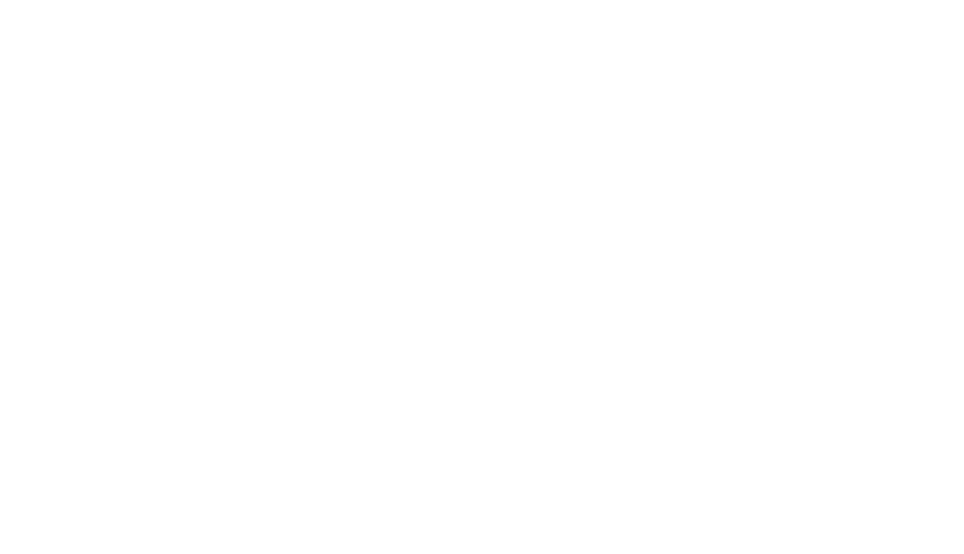

In [ ]:
def eqn(t,y,Q):
  # Constants
  T0 = 400
  Ka = 5000
  Ea = 1e04
  R = 1.987
  Kb = 1e06
  Eb =1.5e04
  dH = -5000
  taw = 60
  Ca0 = 1
  Cas = 0.4977
  Cbs = 0.5023
  Ts = 426.743
  Cp = 1000
  V = 100
  Qs = 40386
  p = 1
  # Equations
  Ca,Cb,T = y
  ra = Ka*np.exp(-Ea/(R*T)) * Ca
  rb = Kb*np.exp(-Eb/(R*T)) * Cb

  dCadt = ((1/taw) *(Ca0 - Ca )) -ra + rb
  dCbdt = ((-1/taw) * Cb) + (ra - rb)
  dTdt = (1/taw) *(T0 - T) + (-dH/(p*Cp)) * (ra - rb) + (Q/(p*Cp*V))
  return[dCadt,dCbdt,dTdt]

Step 1 : Offline simulation data generation

-- initial value problem (Euler,RK4)

We have 4 different initial conditions

In [ ]:
Cas = 0.4977
Cbs = 0.5023
Ts = 426.743
Qs = 40386

ICS = [[Cas - 0.15,Cbs +0.2 , Ts + 50],
       [Cas + 0.09,Cbs -0.17 , Ts - 40],
       [Cas + 0.17,Cbs - 0.3 , Ts - 40],
       [Cas - 0.15,Cbs +0.17 , Ts + 50]]

ICS = np.array([[0.35,0.7,476],[0.6,0.35,386],[0.65,0.2,390],[0.35,0.67,480]])
print(ICS)

[[3.50e-01 7.00e-01 4.76e+02]
 [6.00e-01 3.50e-01 3.86e+02]
 [6.50e-01 2.00e-01 3.90e+02]
 [3.50e-01 6.70e-01 4.80e+02]]


Solving the ODE system with solve_ivp function of scipy.inetgrate library

Inputs  : Q

Outputs : Ca,CB,T

For obtaining a general data we need to solve for different values of Q

Text(0, 0.5, 'Cb')

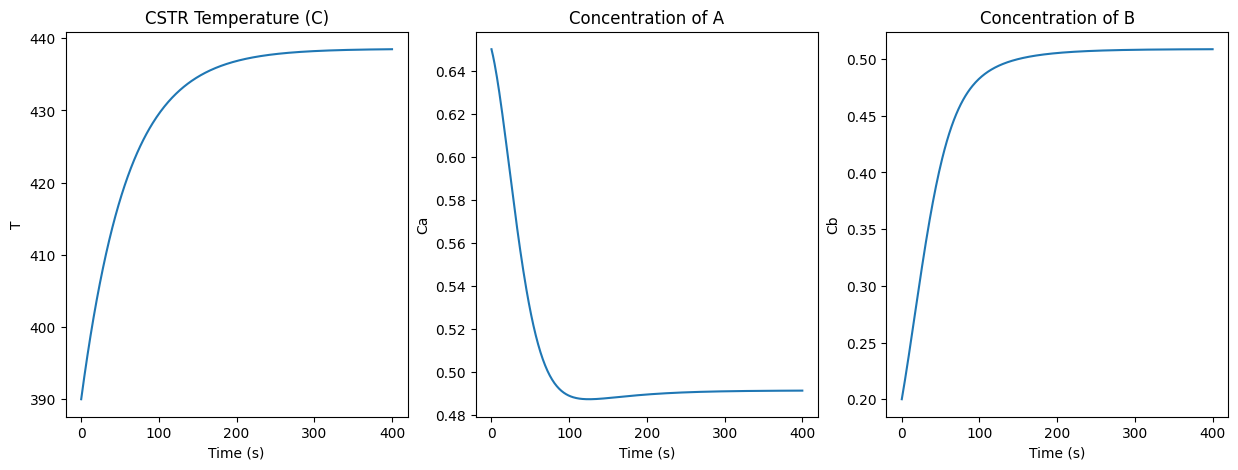

In [ ]:
Q = 59983
out = solve_ivp(eqn,[0,400],ICS[2],args=(Q,),first_step =1 , max_step = 1 )
time = out.t
Ca = out.y[0]
Cb = out.y[1]
T = out.y[2]



fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
axes = axes.flatten()

#Drawing Temperature
axes[0].plot(time,T)
axes[0].set_title("CSTR Temperature (C)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("T")

#Drawing Concentration A
axes[1].plot(time,Ca)
axes[1].set_title("Concentration of A")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Ca")

#Drawing Concentration B
axes[2].plot(time,Cb)
axes[2].set_title("Concentration of B")
axes[2].set_xlabel("Time (s)")
axes[2].set_ylabel("Cb")


In [ ]:
upper_Q = 40000+ Qs
lower_Q = -40000 + Qs
Q = np.arange(lower_Q ,upper_Q, 500)
Q.shape

(160,)

In [ ]:

data = pd.DataFrame(columns=["Time","Q","T","Ca","Cb","IC"])
st = {"Q":[],"Ts":[],"Cas":[],"Cbs":[]}
for q in tqdm(Q):
  for i,ic in enumerate(ICS):
    temp_df = pd.DataFrame(columns=["Time","Q","T","Ca","Cb","IC"])
    out = solve_ivp(eqn,[0,400],ic,args=(q,),first_step =1 , max_step = 1 )
    temp_df["Time"] = out.t
    temp_df['Ca'] = out.y[0]
    temp_df['Cb'] = out.y[1]
    temp_df['T'] = out.y[2]
    temp_df["Q"] = q
    temp_df["IC"] = i

    data  = pd.concat([data,temp_df],axis=0)
data

  0%|          | 0/160 [00:00<?, ?it/s]

,Time,Q,T,Ca,Cb,IC
0,0.0,386,476.000000,0.350000,0.700000,0
1,1.0,386,474.559480,0.398379,0.650794,0
2,2.0,386,473.205188,0.433475,0.614886,0
3,3.0,386,471.917751,0.459097,0.588465,0
4,4.0,386,470.683696,0.477875,0.568901,0
...,...,...,...,...,...,...
396,396.0,79886,450.486982,0.496764,0.503263,3
397,397.0,79886,450.486339,0.496763,0.503263,3
398,398.0,79886,450.485705,0.496763,0.503264,3
399,399.0,79886,450.485083,0.496762,0.503264,3


**LSTM Model : T,Ca,Cb = F_LSTM (Q,T_t-1,Ca_t-1,Cb_t-1)**

Data precprocessing

Checking the distributions

<ipython-input-338-5af7f8b6367d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["T"],ax=axes[0],axlabel="Temperature")
<ipython-input-338-5af7f8b6367d>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["Ca"],ax=axes[1],axlabel="Concentration A")
<ipython-input-338-5af7f8b6367d>:11: Us

Text(0.5, 1.0, 'Cb distribution')

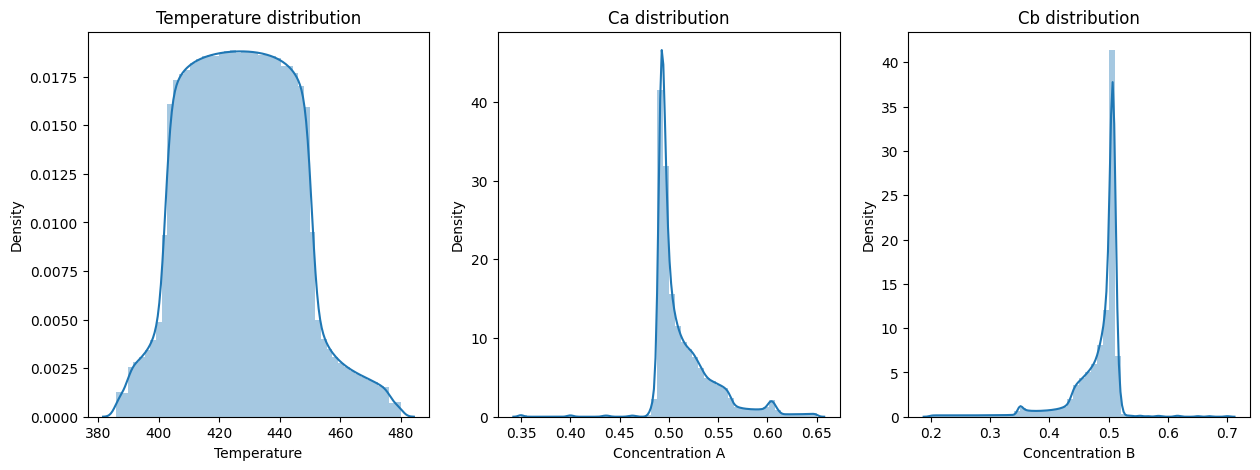

In [ ]:

fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(15,5))
axes = axes.flatten()

# Temperature
sns.distplot(data["T"],ax=axes[0],axlabel="Temperature")
axes[0].set_title("Temperature distribution")
# Concentration A
sns.distplot(data["Ca"],ax=axes[1],axlabel="Concentration A")
axes[1].set_title("Ca distribution")
# Concentration B
sns.distplot(data["Cb"],ax=axes[2],axlabel="Concentration B")
axes[2].set_title("Cb distribution")

<Axes: >

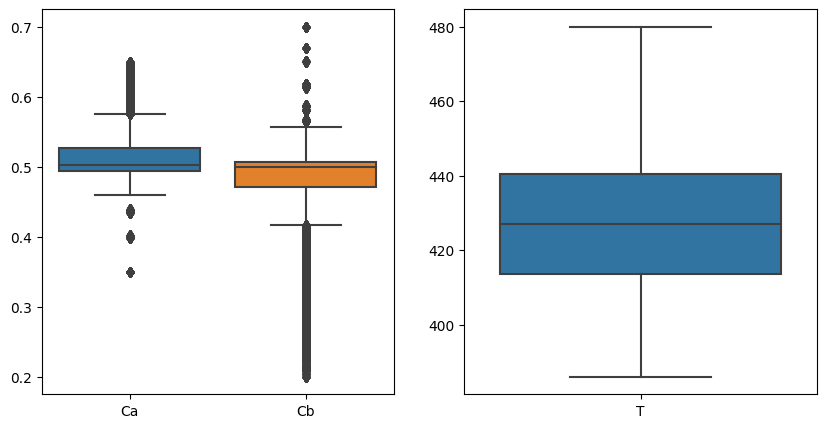

In [ ]:
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
axes = axes.flatten()
sns.boxplot(data[["Ca","Cb"]],ax=axes[0])
sns.boxplot(data[["T"]],ax=axes[1])

Choosing two random time-series data

In [ ]:
import random
rand_q = random.choices(Q,k=1)[0]
rand_i = random.randint(0,3)
fil = (data["IC"] == rand_i) & (data["Q"] == rand_q)
df = data[fil]

In [ ]:
rand_q2 = random.choices(Q,k=1)[0]
rand_i2 = random.randint(0,3)
fil2 = (data["IC"] == rand_i2) & (data["Q"] == rand_q2)
df2= data[fil2]

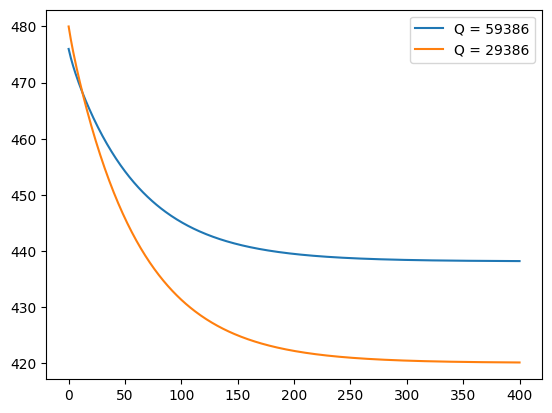

In [ ]:
plt.plot(df["Time"],df["T"],label=f"Q = {rand_q}")
plt.plot(df2["Time"],df2["T"],label=f"Q = {rand_q2}")
plt.legend()

In [ ]:
number_of_time_series = len(Q) * len(ICS)
fil = data['Time'] ==170
computed_n_time = data[fil].shape[0]

In [ ]:
print(number_of_time_series)
print(computed_n_time)

640
640


Spliting data

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
features =["Q","T","Ca","Cb"]
targets = ["T","Ca","Cb"]
test_size = 0.2
X1= df[features]
Y1 = df[targets]
X_train1,X_test1,y_train1,y_test1 = train_test_split(X1,Y1,test_size=test_size,shuffle=False)
X2= df2[features]
Y2 = df2[targets]
X_train2,X_test2,y_train2,y_test2 = train_test_split(X2,Y2,test_size=test_size,shuffle=False)

X_train = np.vstack([X_train1,X_train2])
y_train = np.vstack([y_train1,y_train2])
X_test = np.vstack([X_test1,X_test2])
y_test = np.vstack([y_test1,y_test2])


Normalizing data

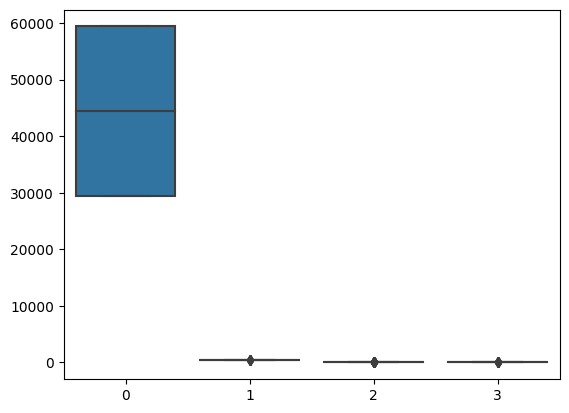

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sns.boxplot(X_train)
input_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
x_train_scaled = input_scaler.fit_transform(X_train)
x_test_scaled = input_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)

<Axes: >

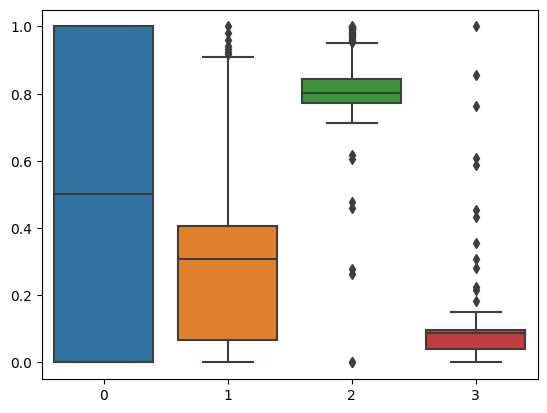

In [ ]:
sns.boxplot(x_train_scaled)

Timeseries Sequence

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator
memory = 5
batch = 1
train_gen = TimeseriesGenerator(X_train,y_train,length=memory,batch_size=1)
print(train_gen[0])
print(df.head(6))

(array([[[59386, 476.0, 0.35, 0.7],
        [59386, 475.1422742221362, 0.39884251787926683,
         0.6503310548118142],
        [59386, 474.35844708252, 0.4349334043223446, 0.6134274007017562],
        [59386, 473.631132439065, 0.4617163662645882,
         0.5858451049604483],
        [59386, 472.9479063011212, 0.48164323441545775,
         0.5651321148361241]]], dtype=object), array([[472.29976936,   0.49648145,   0.54952077]]))
   Time      Q           T        Ca        Cb IC
0   0.0  59386  476.000000  0.350000  0.700000  0
1   1.0  59386  475.142274  0.398843  0.650331  0
2   2.0  59386  474.358447  0.434933  0.613427  0
3   3.0  59386  473.631132  0.461716  0.585845  0
4   4.0  59386  472.947906  0.481643  0.565132  0
5   5.0  59386  472.299769  0.496481  0.549521  0


**LSTM Archtecture implementation with Keras**


In [ ]:
memory = 5
batch = 1
train_gen = TimeseriesGenerator(x_train_scaled,y_train_scaled,length=memory,batch_size=1)
test_gen = TimeseriesGenerator(x_test_scaled,y_test_scaled,length=memory,batch_size=1)

In [ ]:
n_features = len(features)

In [ ]:
model = Sequential()
model.add(LSTM(10,activation= "tanh",return_sequences = True,input_shape = (memory,n_features)))
model.add(LSTM(5,activation= "tanh"))
model.add(Dense(3,activation = "linear"))
model.compile(optimizer =keras.optimizers.Adam(learning_rate=0.002),loss = "mse")

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_41 (LSTM)              (None, 5, 10)             600       
                                                                 
 lstm_42 (LSTM)              (None, 5)                 320       
                                                                 
 dense_20 (Dense)            (None, 3)                 18        
                                                                 
Total params: 938 (3.66 KB)
Trainable params: 938 (3.66 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


LSTM Training with 15 epochs

In [ ]:
epochs = 20
history = model.fit(train_gen,epochs=epochs,batch_size=64,validation_data=test_gen)

Epoch 1/20
635/635 [==============================] - 10s 10ms/step - loss: 0.0128 - val_loss: 0.0013
Epoch 2/20
635/635 [==============================] - 5s 8ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 3/20
635/635 [==============================] - 5s 8ms/step - loss: 0.0021 - val_loss: 9.4291e-04
Epoch 4/20
635/635 [==============================] - 6s 9ms/step - loss: 0.0018 - val_loss: 6.1235e-04
Epoch 5/20
635/635 [==============================] - 5s 7ms/step - loss: 0.0018 - val_loss: 6.0840e-04
Epoch 6/20
635/635 [==============================] - 5s 8ms/step - loss: 0.0017 - val_loss: 7.0309e-04
Epoch 7/20
635/635 [==============================] - 5s 8ms/step - loss: 0.0014 - val_loss: 0.0131
Epoch 8/20
635/635 [==============================] - 5s 8ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/20
635/635 [==============================] - 5s 8ms/step - loss: 0.0014 - val_loss: 6.0207e-04
Epoch 10/20
635/635 [==============================] - 5s 8ms/step - loss: 0.0

<Axes: >

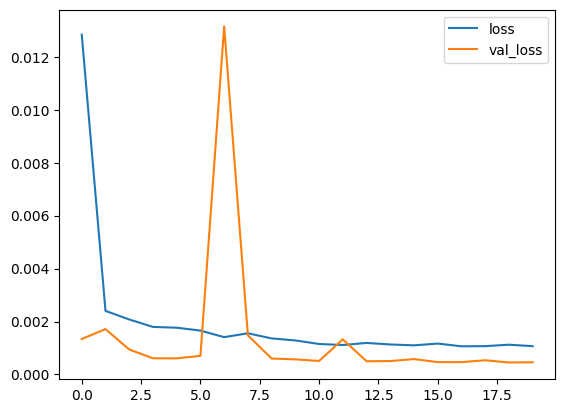

In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df[["loss","val_loss"]].plot()

Predicting the time series based on initial values

In [ ]:
def predict_time_series(df,memory,input_scaler,target_scaler,steps):
  first_batch=df[features].head(memory).values.astype(float)
  first_batch = input_scaler.transform(first_batch)
  current_batch = first_batch.reshape(1,first_batch.shape[0],first_batch.shape[1])
  temp_out = []
  for st in range(steps):
    pred = model.predict(current_batch,verbose=False)[0]
    temp_out.append(pred)
    next = np.append(current_batch[0,-1,0],temp_out[-1]).reshape(1,1,current_batch.shape[2])
    # print(f"{pred}--{next}")
    current_batch = np.append(current_batch[:,1:,:],next,axis=1)
  temp_out = target_scaler.inverse_transform(temp_out)
  head=df[targets].head(memory).values.astype(float)
  pred_df = pd.DataFrame(np.vstack((head,temp_out)),columns=targets)
  return pred_df


In [ ]:
steps = df.shape[0] - memory
steps2 = df2.shape[0] - memory

time_series_1_pred = predict_time_series(df,memory,input_scaler,target_scaler,steps)
time_series_2_pred = predict_time_series(df2,memory,input_scaler,target_scaler,steps2)

In [ ]:
df[features].head(6)

,Q,T,Ca,Cb
0,59386,476.000000,0.350000,0.700000
1,59386,475.142274,0.398843,0.650331
2,59386,474.358447,0.434933,0.613427
3,59386,473.631132,0.461716,0.585845
4,59386,472.947906,0.481643,0.565132
5,59386,472.299769,0.496481,0.549521


In [ ]:
def ploting_LSTM_predictions(df,pred_values):
  test_idx = int(df.shape[0]*0.8)
  fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(18,5))
  axes = axes.flatten()
  fig.suptitle(f"Q = {df['Q'].iloc[0]} ")
  axes[0].plot(df["Time"],df["T"],label = "First-principle",linewidth=3)
  axes[0].plot(df["Time"],pred_values["T"],'--',label = "LSTM",linewidth=3)
  split_d = np.arange(pred_values["T"].min()-10,pred_values["T"].max() +10)
  axes[0].plot(np.full_like(split_d,test_idx),split_d,'--',label = "Train-Test Seperation",color="black")

  axes[0].set_title("Temperature")
  axes[0].set_xlabel("Time (s)")
  axes[0].set_ylabel("T")
  axes[0].legend()

  axes[1].plot(df["Time"],df["Ca"],label = "First-principle",linewidth=3)
  axes[1].plot(df["Time"],pred_values["Ca"],'--',label = "LSTM",linewidth=3)
  split_c = np.arange(pred_values["Ca"].min(),pred_values["Ca"].max())
  axes[1].plot(np.full_like(split_c,test_idx),split_c,'--',label = "Train-Test Seperation",color="black")
  axes[1].set_title("Concentration A")
  axes[1].set_xlabel("Time (s)")
  axes[1].set_ylabel("$C_{a}$")
  axes[1].legend()

  axes[2].plot(df["Time"],df["Cb"],label = "First-principle",linewidth=3)
  axes[2].plot(df["Time"],pred_values["Cb"],'--',label = "LSTM",linewidth=3)
  split_d = np.arange(pred_values["Cb"].min(),pred_values["Cb"].max())
  axes[2].plot(np.full_like(split_d,test_idx),split_d,label = "Train-Test Seperation",color="black")
  axes[2].set_title("Concentration A")
  axes[2].set_xlabel("Time (s)")
  axes[2].set_ylabel("$C_{a}$")
  axes[2].legend()

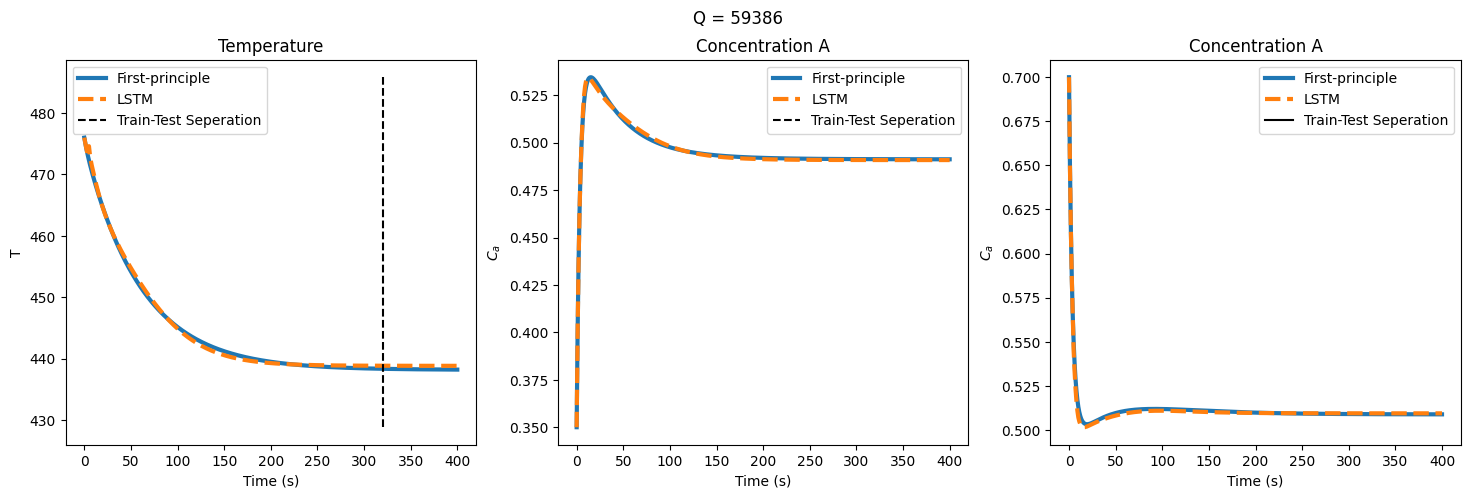

In [ ]:
ploting_LSTM_predictions(df,time_series_1_pred)

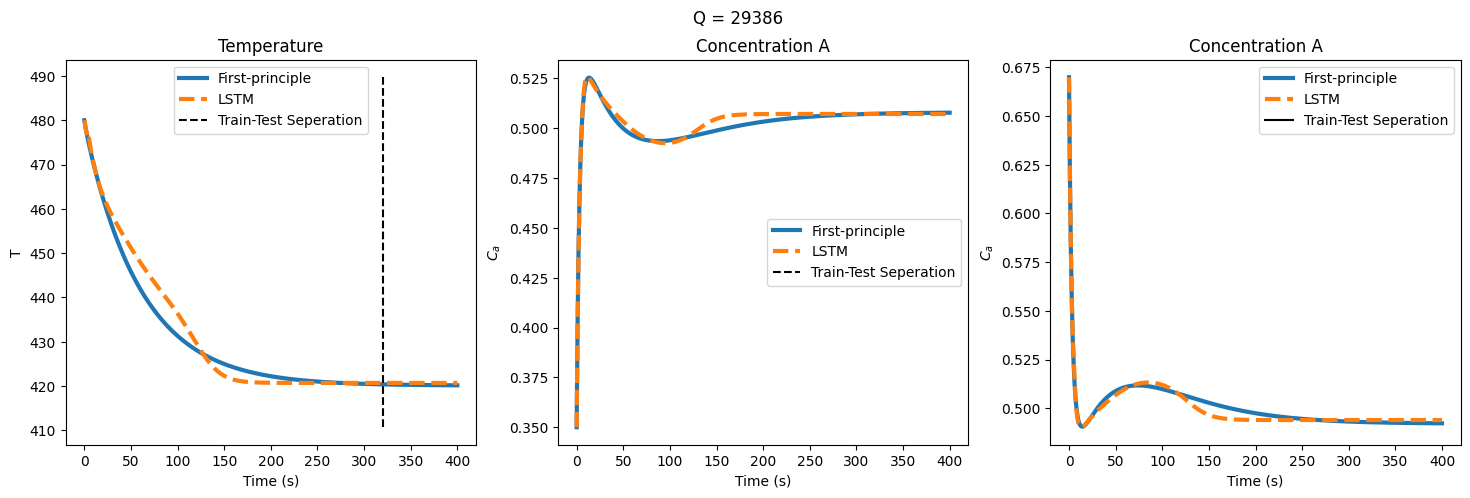

In [ ]:
ploting_LSTM_predictions(df2,time_series_2_pred)

In [ ]:
from sklearn.metrics import mean_squared_error,r2_score
def RMSE(y_pred,y_true):
    return np.sqrt(mean_squared_error(y_pred,y_true))


T_RMSE_1 = RMSE(time_series_1_pred["T"],df["T"])
Ca_RMSE_1 = RMSE(time_series_1_pred["Ca"],df["Ca"])
Cb_RMSE_1 = RMSE(time_series_1_pred["Cb"],df["Cb"])

T_RMSE_2 = RMSE(time_series_2_pred["T"],df2["T"])
Ca_RMSE_2 = RMSE(time_series_2_pred["Ca"],df2["Ca"])
Cb_RMSE_2 = RMSE(time_series_2_pred["Cb"],df2["Cb"])

RMSEs = {"T":[T_RMSE_1,T_RMSE_2],
         "Ca":[Ca_RMSE_1,Ca_RMSE_2],
         "Cb":[Cb_RMSE_1,Cb_RMSE_2]}
pd.DataFrame(RMSEs)

,T,Ca,Cb
0,0.468656,0.000913,0.001095
1,2.674070,0.002571,0.002589


In [ ]:
T_r2_1 = r2_score(time_series_1_pred["T"],df["T"])
Ca_r2_1 = r2_score(time_series_1_pred["Ca"],df["Ca"])
Cb_r2_1 = r2_score(time_series_1_pred["Cb"],df["Cb"])

T_r2_2 = r2_score(time_series_2_pred["T"],df2["T"])
Ca_r2_2 = r2_score(time_series_2_pred["Ca"],df2["Ca"])
Cb_r2_2 = r2_score(time_series_2_pred["Cb"],df2["Cb"])

r2= {"T":[T_r2_1,T_r2_2],
         "Ca":[Ca_r2_1,Ca_r2_2],
         "Cb":[Cb_r2_1,Cb_r2_2]}
pd.DataFrame(r2)

,T,Ca,Cb
0,0.997033,0.995955,0.993860
1,0.967762,0.953001,0.963539
